---
title: "Graded Problem Set: Investment and Portfolio Management"
subtitle: "Imperial College London - Business School"
author: 
  - name: "Rodolphe Lajugie"
date: "2025-10-31"
format: pdf
fontsize: 12pt
geometry: margin=1in
titlepage: true
titlepage-geometry: "top=2cm, bottom=2cm, left=2cm, right=2cm"
---
\newpage
\tableofcontents
\listoffigures
\newpage
\listoftables
\newpage

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

Let's begin the analysis by looking at the structure of the dataset.

In [2]:
stock_prices = pd.read_excel('Problem set data.xls', sheet_name='Stock Prices')
stock_prices.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 216 entries, 0 to 215
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Date          216 non-null    object 
 1   Ticker        216 non-null    object 
 2   Company Name  216 non-null    object 
 3   Close Price   216 non-null    float64
 4   High Price    216 non-null    float64
 5   Low Price     216 non-null    float64
dtypes: float64(3), object(3)
memory usage: 10.3+ KB


In [3]:
stock_prices['Date'] = pd.to_datetime(
    stock_prices['Date'], format="%Y-%m", errors='coerce')

In [4]:
#| label: stock_prices_pivot
#| tbl-cap: "Pivoted stock prices dataframe"
prices_wide = stock_prices.pivot_table(
    index='Date', columns='Ticker', values='Close Price').sort_index()

prices_wide.head()

Ticker,AAPL,AMZN,GE
Date,,,
2019-01-01,166.44,1718.73,10.16
2019-02-01,173.15,1639.83,10.39
2019-03-01,189.95,1780.75,9.99
2019-04-01,200.67,1926.52,10.17
2019-05-01,175.07,1775.07,9.44


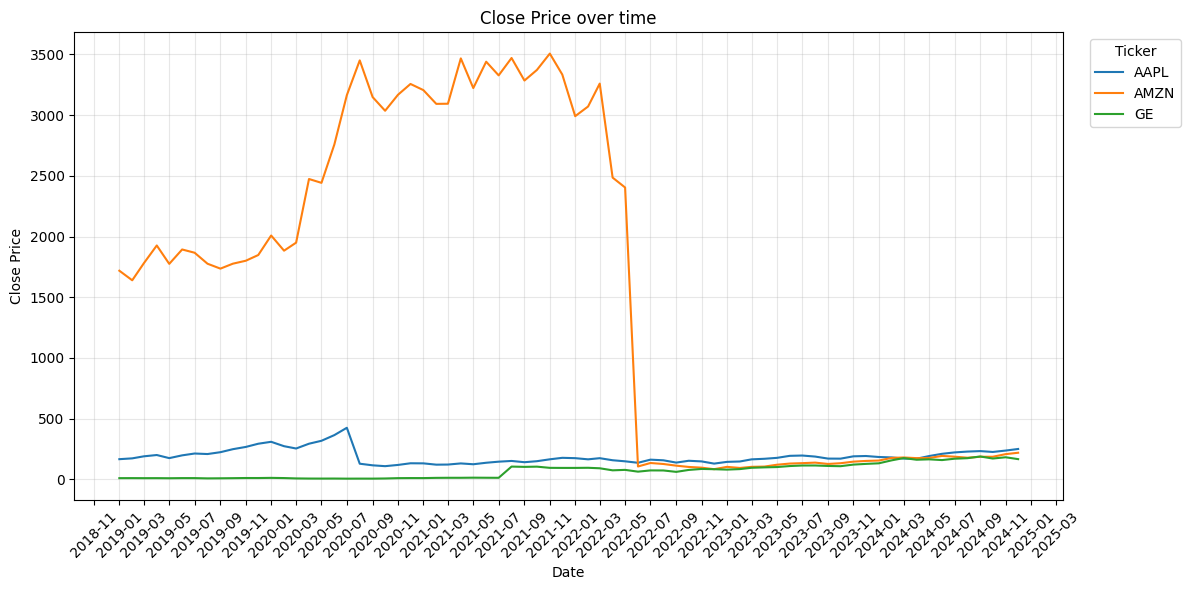

In [5]:
#| label: stock_prices_plot
#| fig-cap: "Close Price over time for different tickers"
plt.figure(figsize=(12, 6))
ax = plt.gca()
for ticker in prices_wide.columns:
    ax.plot(prices_wide.index, prices_wide[ticker], label=ticker)
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Close Price over time')
plt.legend(title='Ticker', bbox_to_anchor=(1.02, 1), loc='upper left')
plt.grid(alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

\newpage

We clearly see that there is some issue on the close price, likely due to stock splits.<br>
Let's try to clean our data so that we escape the stock split issue. First, let's identify the dates where stock splits happened for each ticker.

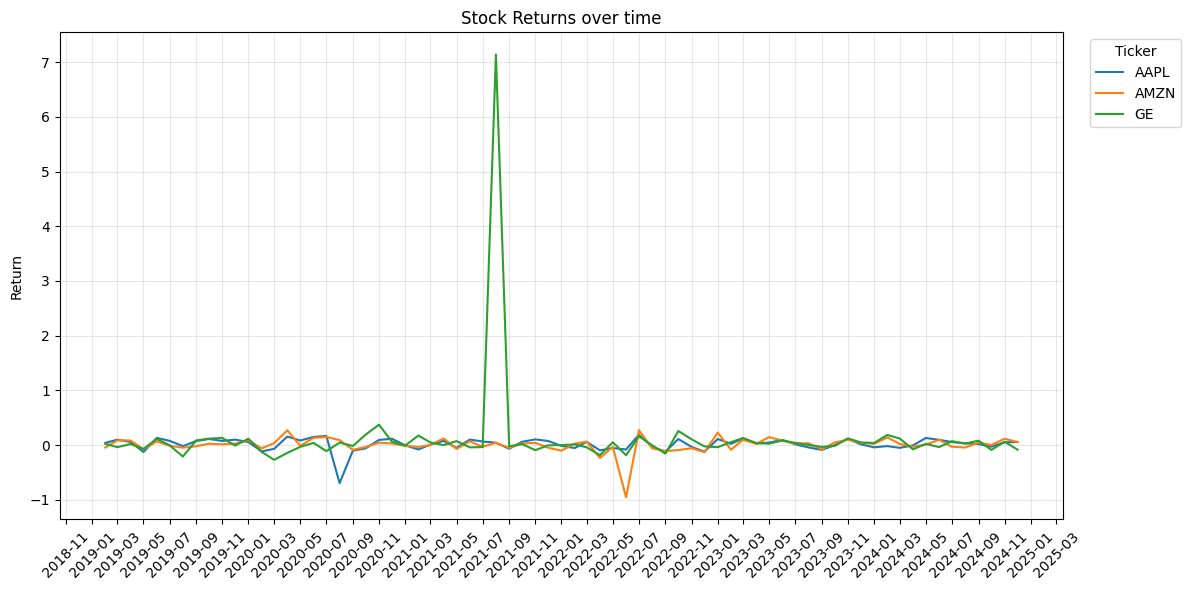

In [6]:
#| label: stock_returns_plot
#| fig-cap: "Stock Returns over time for different tickers"

stock_prices = stock_prices.sort_values(by=['Ticker', 'Date']).reset_index(drop=True)
stock_prices['Return'] = stock_prices.groupby('Ticker')['Close Price'].pct_change()
stock_prices = stock_prices.dropna(subset=['Return'])

plt.figure(figsize=(12, 6))
ax = plt.gca()
for ticker in stock_prices['Ticker'].unique():
    ticker_data = stock_prices[stock_prices['Ticker'] == ticker]
    ax.plot(ticker_data['Date'], ticker_data['Return'], label=ticker)
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

plt.ylabel('Return')
plt.legend(title='Ticker', bbox_to_anchor=(1.02, 1), loc='upper left')
plt.title('Stock Returns over time')
plt.grid(alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Here we get the stock split or reverse stock split events for each ticker (outlier).

In [7]:
#| label: stock_split_events
#| tbl-cap: "Identified stock split or reverse stock split events"
df_split_events = stock_prices[np.abs(
    stock_prices['Return']) >= 0.50].copy()
df_split_events

,Date,Ticker,Company Name,Close Price,High Price,Low Price,Return
19,2020-08-01,AAPL,APPLE INC,129.04,131.00,107.8925,-0.696405
113,2022-06-01,AMZN,AMAZON.COM INC,106.21,128.99,101.4300,-0.955823
175,2021-08-01,GE,GE AEROSPACE,105.41,107.23,98.1100,7.139768


After some research on the internet, I've found the following stock split events:
- AAPL: 2020-08 (4-for-1)
- GE: 2021-08 (1-for-8 reverse split)
- AMZN: 2022-06 (20-for-1)

So now we can adjust the closing prices accordingly.

\newpage

In [8]:
split_events = {
    ('AAPL','2020-08-01'): 4,
    ('AMZN','2022-06-01'): 20,
    ('GE','2021-08-01'): 1/8,
}

for (ticker, date_str), split_factor in split_events.items():
    date = pd.to_datetime(date_str)
    index_t = stock_prices[(stock_prices['Ticker'] == ticker) &
                        (stock_prices['Date'] == date)].index
    
    index_t = index_t[0]
    index_t_minus_1 = index_t - 1
    P_t = stock_prices.loc[index_t, 'Close Price']
    P_t_minus_1 = stock_prices.loc[index_t_minus_1, 'Close Price']

                # La formule utilise le facteur de split
    adjusted_return = ((P_t * split_factor) / P_t_minus_1) - 1
    stock_prices.loc[index_t, 'Return'] = adjusted_return 

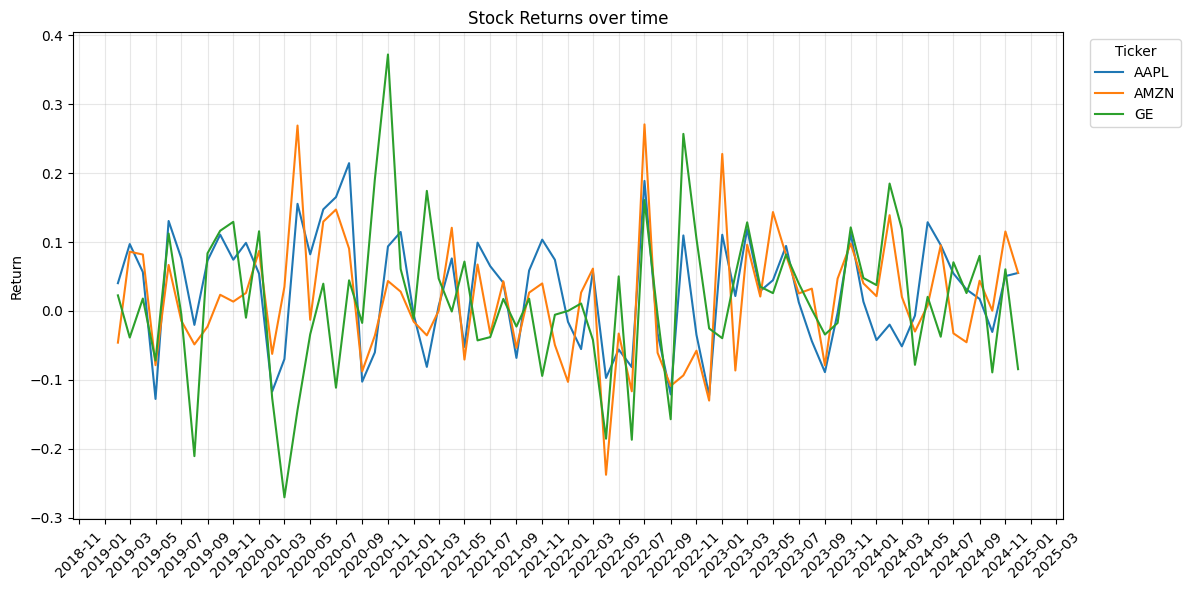

In [9]:
#| label: stock_returns_adjusted_plot
#| fig-cap: "Adjusted Stock Returns over time for different tickers"
df_final_returns_adj = stock_prices[['Date', 'Ticker', 'Company Name',
                                     'Return']].dropna(subset=['Return']).copy()

plt.figure(figsize=(12, 6))
ax = plt.gca()
for ticker in df_final_returns_adj['Ticker'].unique():
    ticker_data = df_final_returns_adj[df_final_returns_adj['Ticker'] == ticker]
    ax.plot(ticker_data['Date'], ticker_data['Return'], label=ticker)
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

plt.ylabel('Return')
plt.legend(title='Ticker', bbox_to_anchor=(1.02, 1), loc='upper left')
plt.title('Stock Returns over time')
plt.grid(alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [10]:
mkt_index = pd.read_excel('Problem set data.xls', sheet_name='Market Index')

In [11]:
mkt_index["Market return"] = mkt_index["Level of the S&P 500 Index"]\
    .pct_change().dropna() 
mkt_index['Date'] = pd.to_datetime(
    mkt_index['Date'], format="%Y-%m", errors='coerce')

In [12]:
rf_rate = pd.read_excel('Problem set data.xls', sheet_name='Risk Free Rate')
rf_rate['Risk Free Rate (Proportion)'] = rf_rate['Return on the T bill (in %)']\
    .apply(lambda x: ((1+(x/100))**(1/12)) - 1)

rf_rate['Date'] = pd.to_datetime(
    rf_rate['Date'], format="%Y-%m", errors='coerce')

In [13]:
df_all = pd.merge(df_final_returns_adj, mkt_index[['Date', 'Market return']],\
                  on='Date', how='left')
df_all = pd.merge(df_all, rf_rate[['Date', 'Risk Free Rate (Proportion)']],\
                  on='Date', how='left')
df_all['Stock excess return'] = df_all['Return'] \
    - df_all['Risk Free Rate (Proportion)']
df_all['Market excess return'] = df_all['Market return'] \
    - df_all['Risk Free Rate (Proportion)']

# A. Covariance Matrix over the three stocks

First, let's rework the stock prices data to compute the monthly returns for each stock.

In [14]:
#| label: stock_returns_pivot_adjusted
#| tbl-cap: "Pivoted adjusted stock returns dataframe"
returns_pivot = df_final_returns_adj.pivot(
    index='Date',
    columns='Ticker',
    values='Return'
).dropna()

returns_pivot.head()

Ticker,AAPL,AMZN,GE
Date,,,
2019-02-01,0.040315,-0.045906,0.022638
2019-03-01,0.097026,0.085936,-0.038499
2019-04-01,0.056436,0.081859,0.018018
2019-05-01,-0.127573,-0.078613,-0.071780
2019-06-01,0.130519,0.066792,0.112288


Now that we do know the returns, we can compute the covariance matrix of the three stocks over the entire period.<br>
Covariance between two stocks $i$ and $j$ is computed as:<br>
$$Cov(R_i, R_j) = \frac{1}{N-1} \sum_{t=1}^{N} (R_{i,t} - \bar{R_i})(R_{j,t} - \bar{R_j})$$

Where: 

- $R_{i,t}$ and $R_{j,t}$ are the return of stock i and j at the time t

- $\bar{R_i}$ and $\bar{R_j}$ are the mean of each column (stock)

- $N$ is the number of observations (periods).

In [15]:
demeaned_returns = returns_pivot - returns_pivot.mean()
n = demeaned_returns.shape[0]
cov_matrix_manual = (demeaned_returns.T @ demeaned_returns) / (n - 1)

In [16]:
# | label: Covariance_matrix_manual
# | tbl-cap: "Covariance matrix between AAPL, AMZN and GE."
cov_matrix_manual

Ticker,AAPL,AMZN,GE
Ticker,,,
AAPL,0.006766,0.004986,0.002481
AMZN,0.004986,0.008038,0.001691
GE,0.002481,0.001691,0.011339


### Other method to compute the covariance matrix

| Method | Description | Pros | Cons |
| :--- | :--- | :--- | :--- |
| **1. CAPM** | Uses only one factor: market return. Covariance is estimated via the $\beta$ of each asset in relation to the market. | **Simplicity**: Requires only one data series (the market). Covariance matrix always defined positive. | Maybe **too simplistic**: ignores other factors that may affect returns. |
| **2. Multi-Factor Models (i.e. Fama-French)** | Uses several factors (e.g. market, company size - SMB, value - HML) to model returns. | **More comprehensive**: Captures various sources of risk. | **Complexity**: Requires more data and sophisticated modeling techniques. |
| **3. Linear Shrinkage** | Combine la matrice de covariance historique ($\Sigma$) avec une matrice cible  ($\Sigma_{cible}$),souvent une matrice à facteur unique ou constante, en utilisant un poids $\delta \in [0,1]$. | **Forecast improved** Reduces noise and estimation errors. Ensures that the matrix is defined positive | Performance depends on the relevance of the chosen target matrix and the smoothing factor |
| **4. Historical Method (chosen)** | Relies solely on historical return data to estimate the covariance matrix. | **Simplicity**: Easy to implement and understand. | **Data sensitivity**: Highly dependent on the chosen historical period. |

\newpage

# B. Historical Sharpe Ratios for three different portfolios

Quick recap of the different portfolios:

| Portfolio | Weights in Apple | Weights in Amazon | Weights in GE |
| --------- | ---------------- | ----------------- | ------------- |
| Portfolio 1 | 33.33% | 33.33% | 33.33% |
| Portfolio 2 | 40% | 40% | 20% |
| Portfolio 3 | 25% | 25% | 50% |

## 1. General Methodology & function redaction

### Sharpe Ratio Calculation
Sharpe Ratio is computed as:<br>
$$SR = \frac{E[R_p] - R_f}{\sigma_p}$$

Where:

- $E[R_p]$ is the expected return of the portfolio

- $R_f$ is the risk-free rate   

- $\sigma_p$ is the standard deviation of the portfolio returns

### Define the function to compute the portfolio expected returns

In [17]:
def portfolio_expected_excess_return(dic_weight: dict, df_all: pd.DataFrame) \
    -> pd.Series:
    keys = list(dic_weight.keys())
    df_tmp = df_all.pivot(
        index='Date',
        columns='Ticker',
        values='Stock excess return'
    ).dropna()

    excess_return = df_tmp[keys[0]]*dic_weight[keys[0]] \
                  + df_tmp[keys[1]]*dic_weight[keys[1]] \
                  + df_tmp[keys[2]]*dic_weight[keys[2]]

    return excess_return

## 2. Portfolio A

Each stock has equal weights of 33.33%.

In [18]:
dic_weight = {'AAPL': 1/3, 'AMZN': 1/3, 'GE': 1/3}
portfolio_expected_excess_return_A = portfolio_expected_excess_return(
    dic_weight,
    df_all
    )

sharpe_ratio_A = \
    portfolio_expected_excess_return_A.mean()\
  / portfolio_expected_excess_return_A.std()

print(
    f"The sharpe ratio for Portfolio A is: {sharpe_ratio_A}")

The sharpe ratio for Portfolio A is: 0.265069079018295


## 3. Portfolio B

Apple and Amazon have weights of 40% each, while GE has a weight of 20%.

In [19]:
dic_weight = {'AAPL': 0.4, 'AMZN': 0.4, 'GE': 0.2}
portfolio_excess_return_B = portfolio_expected_excess_return(
    dic_weight, 
    df_all
    )

sharpe_ratio_B = \
    portfolio_excess_return_B.mean()\
  / portfolio_excess_return_B.std()

print(f"The sharpe ratio for Portfolio B is: {sharpe_ratio_B}")

The sharpe ratio for Portfolio B is: 0.2747369701297241


\newpage

## 4. Portfolio C

GE has a weight of 50%, while Apple and Amazon have weights of 25% each.

In [20]:
dic_weight = {'AAPL': 0.25, 'AMZN': 0.25, 'GE': 0.5}

portfolio_excess_return_C = portfolio_expected_excess_return(
    dic_weight,
    df_all)

sharpe_ratio_C = \
    portfolio_excess_return_C.mean()\
  / portfolio_excess_return_C.std()
    
print(f"The sharpe ratio for Portfolio C is: {sharpe_ratio_C}")

The sharpe ratio for Portfolio C is: 0.2365065375896759


In [21]:
# | label: tbl-summary-sharp
# | tbl-cap: "Summary of sharpe ratios for Portfolios A B and C."
df_sharpe = pd.DataFrame({
    "Portfolio": ["A", "B", "C"],
    "Sharpe": [sharpe_ratio_A.round(4), 
               sharpe_ratio_B.round(4), 
               sharpe_ratio_C.round(4)]
})
df_sharpe

,Portfolio,Sharpe
0,A,0.2651
1,B,0.2747
2,C,0.2365


The greater the Sharpe ratio, the better the risk-adjusted performance of the portfolio. Having said that all portfolios have a similar Sharpe ratio, with Portfolio B being slightly better due to its higher allocation to Apple and Amazon compared to GE. 

\newpage

# C. Risky portfolio weights

## 1. Context and methodology

Here, we get to find the weight that each of the investors would invest in the risky portfolio (composed of the three stocks) versus the risk-free asset, based on their risk aversion. 

The Expected return of the complete portfolio is computed as:<br>
$$E[R_c] = \omega_r E[R_p] + (1 - \omega_r) R_f = R_f + \omega_r (E[R_p] - R_f)$$

Where:
- $\omega_r$ is the weight in the risky portfolio
- $p$ is the risky portfolio
- $R_f$ is the risk-free rate
- $c$ is the complete portfolio


Utility function is defined as:<br>
$$U = E[R_c] - \frac{1}{2} A \sigma_c^2$$
Where:
- $A$ is the risk aversion coefficient

To maximize the utility function, we need to first substitute the expected return and variance of the complete portfolio into the utility function, then derive regarding $\omega_r$ and set it to zero to find the optimal weight $\omega_r^*$.<br>
We start by substituting $E[R_c]$ and $\sigma_c^2$ into the utility function:<br>
$$U = R_f + \omega_r (E[R_p] - R_f) - \frac{1}{2} A \omega_r^2 \sigma_p^2$$
$$\Rightarrow \frac{\partial U}{\partial \omega_r} = (E[R_p] - R_f) - A \omega_r \sigma_p^2 = 0$$
$$\Leftrightarrow \omega_r^* = \frac{E[R_p] - R_f}{A \sigma_p^2}$$

Now, we only need to find the risk aversion for each investor to compute their optimal weight in the risky portfolio.


\newpage

In [22]:
def get_risk_aversion(a: int) -> float:
    """
    Here we compute the risk aversion from the utility function.
    Args:
        a (int): The coefficient of risk aversion.

    Returns:
        float: The risk aversion coefficient.
    """
    return 2*a

def compute_optimal_weight(risk_aversion: float, 
                           excess_return: float,
                           portfolio_variance: float) -> float:

    weight = excess_return / (risk_aversion * portfolio_variance)
    if weight <= 1:
        return weight
    else:
        excedent = weight - 1
        weighted_excedent = excedent/weight
        
        return 1 + weighted_excedent*(excess_return - 0.02)/(risk_aversion * portfolio_variance)

## 2. Computation of risky portfolio weights for each investor

Here are the utility functions for each investor:

| Investor | Utility Function |
| :--- | :--- |
| X | $U = E[R_c] - \sigma_c^2$ |
| Y | $U = E[R_c] - 2\sigma_c^2$ |
| Z | $U = E[R_c] - 0.1\sigma_c^2$ |

\newpage

In [23]:
risk_aversion_X = get_risk_aversion(1)
risk_aversion_Y = get_risk_aversion(2)
risk_aversion_Z = get_risk_aversion(0.1)

excess_return = 0.1
variance_portfolio = 0.3

optimal_weight_X = compute_optimal_weight(
    risk_aversion_X,
    excess_return,
    variance_portfolio
)

optimal_weight_Y = compute_optimal_weight(
    risk_aversion_Y,
    excess_return,
    variance_portfolio
)

optimal_weight_Z = compute_optimal_weight(
    risk_aversion_Z,
    excess_return,
    variance_portfolio
)

print(f"Optimal weight for investor X: {optimal_weight_X:.4f}\
 for a risk aversion of {risk_aversion_X}")
print(f"Optimal weight for investor Y: {optimal_weight_Y:.4f}\
 for a risk aversion of {risk_aversion_Y}")
print(f"Optimal weight for investor Z: {optimal_weight_Z:.4f}\
 for a risk aversion of {risk_aversion_Z}")

Optimal weight for investor X: 0.1667 for a risk aversion of 2
Optimal weight for investor Y: 0.0833 for a risk aversion of 4
Optimal weight for investor Z: 1.5333 for a risk aversion of 0.2


At first sight it is quite surprising to have such a weight for investor Z. However, looking at his risk aversion coefficient of 0.2 (very low), it makes sense that he would invest a lot in the risky portfolio since he is not very averse to risk. We can then interprete the result as he would borrow money at the risk-free rate to invest even more than what he has in the risky portfolio.

\newpage

# D. Return on stocks assuming APT model

## 1. Methodology

The single factor chosen is the Market excess return $r_M$.<br>
The objective is to calculate the expected return ($E(R_i)$) for each asset for the next period.<br>


the relationship between a stock's excess return $r_i$ and the factor's excess return (here, the market $r_M$) is modeled by a simple linear regression:<br>
$$r_{i} = \alpha_i + \beta_i r_{Mkt} + \epsilon_{i}$$

Where:

- $r_{i}$ is the stock i's excess return

- $r_{Mkt}$ is the market's excess return

- $\alpha_i$ is the regression intercept

- $\beta_i$ is the sensitivity of stock i to the market excess return

- $\epsilon_{i}$ is the stock specific error term

To estimate the Expected Total Return $E(R_i)$ for the future period, we use the expected form of the APT equation, which, in this single-factor case, is identical to the CAPM. We assume the alpha and the specific error term are zero in the forecast:
$$E(R_i) = R_{f, next month} + \beta_i E(r_{Mkt, next month})$$


### 1. Compute each stock's $\beta$ using linear regression

To compute the $\beta$ of each stock, we will use the formula:
$$\beta_i = \frac{Cov(R_i, R_{Mkt})}{Var(R_{Mkt})}$$

In [24]:
dic_results = {'beta':{}, 'return':{}}
for tic in df_all['Ticker'].unique():
    df_tmp = df_all[df_all['Ticker'] == tic].copy()
    dic_results['beta'][tic] = round(np.cov(df_tmp['Return'], 
            df_tmp['Market return'])[0, 1]/df_tmp['Market return'].var(), 4)

\newpage

### 2. Estimate the market excess return for the next month

Estimated using the historical average of the Market Excess Return from the dataset.

In [25]:
# To get only values once (otherwise we get once per ticker)
df_tmp = df_all[df_all['Ticker'] == 'AAPL'] 

historical_market_excess_return = df_tmp['Market excess return'].mean()

### 3. Find risk free rate for the next month

Estimated using the last available risk-free rate in the dataset.

In [26]:
rf_next = df_tmp['Risk Free Rate (Proportion)'].iloc[-1]

### 4. Compute the expected return for each stock using the APT Formula
$$E(R_i) = R_{f, next month} + \beta_i E(r_{Mkt, next month})$$

In [27]:
#| label: tbl-result-beta-return
#| tbl-cap: "Estimated betas and expected returns for each stock using the APT formula"
for tic in dic_results['beta'].keys():
    dic_results["return"][tic] = rf_next + \
        dic_results['beta'][tic] * historical_market_excess_return

pd.DataFrame(dic_results)

,beta,return
AAPL,1.2591,0.016587
AMZN,1.1408,0.015374
GE,1.2355,0.016345


\newpage

# E. Robust Minus Weak factor

## 1. Definition & logic

The Robust Minus Weak factor, as defined in the Fama French five-factor model, captures the excess returns of a portfolio of "robust" stocks over "weak" stocks. It captures the idea that more profitables companies have better prospects for future growth, which translates into a positive risk premium.

## 2. Statistical significance of the factor

- The RMW factor is statistically significant, as it explains asset returns beyond the market factor and the traditional SMB and HML factors.<br>
It is also theoretically grounded: this distinguishes it from purely empirical or data-mined factors discovered by chance. A theoretically justified factor is less likely to be a false positive, unlike many “factor zoo” anomalies

- The RMW factor provides proven incremental explanatory value. Its inclusion in the Fama–French five-factor model significantly improves the model’s R^2 compared to the three-factor version, capturing profitability-related anomalies that SMB and HML fail to explain. Moreover, empirical evidence shows that RMW’s average return exhibits a t-statistic exceeding the critical threshold of 3.0 suggested by Harvey et al. (2016), confirming its robustness and distinguishing it from spurious “factor zoo” findings

\newpage

# F. Rational Explanation of RMW's predictive power

## 1. Rational Explanation

According to Fama and French (2015), the RMW factor is anchored in the Dividend Discount Model (DDM) and the theory of effective investment:
- Companies with robust exploitation rentability have more stable cash flows, and higher, which supports higher valuations as they are less risky then
- For a given level of accounting value, a more profitable company must have better prospects for future profit growth and, therefore, a higher price today
- The RMW pays investors for holding these high-quality companies. The RMW premium is the excess return that investors receive from holding these companies, which are considered a systematic type of risk related to the company's ability to generate profits

## 2. $\beta_{RMW}$ analysis

$\beta_{RMW}$ is computed as: $R_{Robust Portfolio} - R_{Weak Portfolio}$
Having said that: 
- a $\beta_{RMW} > 0$ indicates the stock return is positively correlated with the robust stocks (high returns)
- a $\beta_{RMW} < 0$ indicates the stock return is positively correlated with the weak stocks (low returns)

About our three stocks:<br>

- Apple would be in the Robust category, with a positif $\beta_{RMW}$. Apple is historically a company with high, stable profit margins and strong cash generation. It aligns perfectly with the characteristics of the Robust wallet.
- Amazon would be in the neutral category, with a $\beta_{RMW}$ close to zero. Amazon has long favored massive growth and reinvestment at the expense of high immediate operating profitability. Historically, it has few characteristics of Fama-French's Robust action.
- General Electric would be in the Weak category, with a negatif $\beta_{RMW}$. Over the recent restructuring period, GE was characterized by debt problems, asset disposals and periods of low or negative operating profitability. It aligns with the Weak wallet [source](https://www.investopedia.com/insights/rise-and-fall-ge/).

\vspace{5\baselineskip}

In this report, all the computed values are monthly unless otherwise specified.